# Preliminary: SHAP and XGBoost 

In [1]:

import shap
import xgboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
# import cupy as cp


## Load dataset


In [2]:
waterqualitypath = "../data/plankton-patrol/Plankton Patrol/Data/plankton-patrol_ChesapeakeWaterQuality.csv"
data = pd.read_csv(waterqualitypath)
data.info()

C:\Users\pushk\AppData\Local\Temp\ipykernel_46904\2510223144.py:2: DtypeWarning: Columns (1,10,11,12,13,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(waterqualitypath)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2162314 entries, 0 to 2162313
Data columns (total 26 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   CBSeg2003            object
 1   EventId              object
 2   Cruise               object
 3   Program              object
 4   Project              object
 5   Agency               object
 6   Source               object
 7   Station              object
 8   SampleDate           object
 9   SampleTime           object
 10  TotalDepth           object
 11  UpperPycnocline      object
 12  LowerPycnocline      object
 13  Depth                object
 14  Layer                object
 15  SampleType           object
 16  SampleReplicateType  object
 17  Parameter            object
 18  Qualifier            object
 19  MeasureValue         object
 20  Unit                 object
 21  Method               object
 22  Lab                  object
 23  Latitude             object
 24  Longitude            obj

### Inspect column names

In [3]:
data.columns

Index(['CBSeg2003', 'EventId', 'Cruise', 'Program', 'Project', 'Agency',
       'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth',
       'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType',
       'SampleReplicateType', 'Parameter', 'Qualifier', 'MeasureValue', 'Unit',
       'Method', 'Lab', 'Latitude', 'Longitude', 'TierLevel'],
      dtype='object')

In [4]:
data["Qualifier"] = data["Qualifier"].replace(np.nan, "=")


columns_to_exclude = ["Parameter", "MeasureValue", "Unit"]
unique_columns = [col for col in data.columns if col not in columns_to_exclude]

df_unique = data[unique_columns].drop_duplicates(subset="EventId")
print(df_unique.shape, data.shape)
data_r = data.pivot_table(
    index=["EventId"], columns="Parameter", values="MeasureValue", aggfunc="first"
).reset_index()
exclude_from_pivoted = ["Parameter", "MeasureValue", "Unit", "SampleDate", "SampleTime"]
pivoted_columns = data_r.columns.tolist()
for ce in exclude_from_pivoted:
    if ce in pivoted_columns:
        pivoted_columns.remove(ce)
data_m = pd.merge(df_unique, data_r, on="EventId", how="left")


print(data_m.columns, data_m.shape)

(20855, 23) (2162314, 26)
Index(['CBSeg2003', 'EventId', 'Cruise', 'Program', 'Project', 'Agency',
       'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth',
       'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType',
       'SampleReplicateType', 'Qualifier', 'Method', 'Lab', 'Latitude',
       'Longitude', 'TierLevel', 'CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP',
       'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH',
       'PHEO', 'PIP', 'PN', 'PO4F', 'PP', 'Parameter', 'SALINITY', 'SECCHI',
       'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS',
       'TURB_NTU', 'VSS', 'WTEMP'],
      dtype='object') (20855, 58)


In [5]:
columns_to_drop = ['EventId']

# Drop the specified columns
data_md = data_m.drop(columns=columns_to_drop)


In [6]:
data_md.head()

,CBSeg2003,Cruise,Program,Project,Agency,Source,Station,SampleDate,SampleTime,TotalDepth,...,SPCOND,TDN,TDP,TN,TON,TP,TSS,TURB_NTU,VSS,WTEMP
0,CB1TF,BAY451,TWQM,MAIN,MDDNR,MDDNR,CB1.1,12/13/2006,10:58:00,7.0,...,195.0,1.67,0.0181,1.7183,0.2773,0.0308,7.3,NaN,2.0,5.5
1,CB1TF,BAY452,TWQM,MAIN,MDDNR,MDDNR,CB1.1,1/12/2007,13:00:00,5.5,...,137.0,1.41,0.0168,1.4958,0.2498,0.0384,11.3,NaN,5.3,5.3
2,CB1TF,BAY454,TWQM,MAIN,MDDNR,MDDNR,CB1.1,3/14/2007,10:41:00,7.0,...,234.0,1.98,0.0183,2.055,0.2902,0.0305,7.4,NaN,3.2,2.6
3,CB1TF,BAY456,TWQM,MAIN,MDDNR,MDDNR,CB1.1,4/11/2007,10:32:00,6.5,...,185.0,1.35,0.0098,1.4153,0.1653,0.0237,8.0,NaN,2.8,7.6
4,CB1TF,BAY457,TWQM,MAIN,MDDNR,MDDNR,CB1.1,4/26/2007,11:46:00,5.5,...,142.0,1.04,0.0132,1.1297,0.1568,0.0331,15.0,NaN,3.0,13.9


In [7]:
pivoted_columns

['EventId',
 'CHLA',
 'DIN',
 'DO',
 'DOC',
 'DON',
 'DOP',
 'DO_SAT_P',
 'FSS',
 'KD',
 'NH4F',
 'NO23F',
 'NO2F',
 'NO3F',
 'PC',
 'PH',
 'PHEO',
 'PIP',
 'PN',
 'PO4F',
 'PP',
 'SALINITY',
 'SECCHI',
 'SIF',
 'SIGMA_T',
 'SPCOND',
 'TDN',
 'TDP',
 'TN',
 'TON',
 'TP',
 'TSS',
 'TURB_NTU',
 'VSS',
 'WTEMP']

In [8]:
set_numeric = [
    "TotalDepth",
    "UpperPycnocline",
    "LowerPycnocline",
    "Depth",
    "Latitude",
    "Longitude",
    "MeasureValue",
    "CHLA",
    "DIN",
    "DO",
    "DOC",
    "DON",
    "DOP",
    "DO_SAT_P",
    "FSS",
    "KD",
    "NH4F",
    "NO23F",
    "NO2F",
    "NO3F",
    "PC",
    "PH",
    "PHEO",
    "PIP",
    "PN",
    "PO4F",
    "PP",
    "Parameter",
    "SALINITY",
    "SECCHI",
    "SIF",
    "SIGMA_T",
    "SPCOND",
    "TDN",
    "TDP",
    "TN",
    "TON",
    "TP",
    "TSS",
    "TURB_NTU",
    "VSS",
    "WTEMP",
]
# set_string = ['
set_date = ["SampleDate", "SampleTime"]


def combine_date_time_strings(df, date_col, time_col):
    # Combine date and time strings
    combined_col = df[date_col] + " " + df[time_col]
    # Convert the combined string to datetime
    datetime_col = "Sample"

    df[datetime_col] = pd.to_datetime(combined_col, errors="coerce")
    df[datetime_col + "_year"] = df[datetime_col].dt.year
    df[datetime_col + "_month"] = df[datetime_col].dt.month
    df[datetime_col + "_day"] = df[datetime_col].dt.day
    df[datetime_col + "_hour"] = df[datetime_col].dt.hour
    df[datetime_col + "_minute"] = df[datetime_col].dt.minute
    df[datetime_col + "_second"] = df[datetime_col].dt.second
    newcolnames = [
        f"{datetime_col}_year",
        f"{datetime_col}_month",
        f"{datetime_col}_day",
        f"{datetime_col}_hour",
        f"{datetime_col}_minute",
        f"{datetime_col}_second",
    ]
    # Drop the original date, time, and combined datetime columns
    df.drop(columns=[date_col, time_col, datetime_col], inplace=True)

    return df, newcolnames


# Function to convert columns to appropriate types
def convert_dtypes(df):
    for col in df.columns:
        df[col] = df[col].replace("nan", np.nan)
        # print(df[col][564463])
        print(f"converting column {col}", end="\t")
        print(df[col].dtype)

        if col not in (set_numeric + set_date):
            df[col] = pd.Categorical(df[col])
            print("Categorical")
        elif col in set_numeric:
            # try:
            # Try converting to numeric (float)
            df[col] = pd.to_numeric(df[col], errors="coerce")
            print("Numeric")
        # except (ValueError, TypeError):
        # try:
        elif col in set_date:
            print("Date, skipped")
            pass
            # Try converting to datetime (date)
            # df[col] = pd.to_datetime(df[col], errors='coerce')
            # except (ValueError, TypeError):
            # Check for categorical
            # unique_ratio = df[col].nunique() / df[col].count()
            # if unique_ratio < 0.2:  # heuristic for categorical, adjustable threshold
            # Convert to string if not numeric, date, or categorical
        else:
            print(f"{col}: string")
            df[col] = df[col].astype(str)
            print("string")
        print(df[col].dtype)
    return df


# Apply the conversion function
datacopy = data_md.__deepcopy__()
data_conv = convert_dtypes(datacopy)
data_cleana, newcols = combine_date_time_strings(data_conv, "SampleDate", "SampleTime")
# Check the result
print(data_cleana.dtypes)
print(data_cleana.shape)
# data.dropna(axis='TotalDepth',how='all')
data_cleana = data_cleana[:-1]
print(data_cleana.shape)

# data_conv = convert_dtypes(data_conv)
# for col in data.columns:
#     # print(data[col])
#     if col not in (set_float + set_date):
#         data[col]= pd.Categorical(df[col])(data[col][1:])
#     # if col in set_string:
#     #     data[col][1:]=data[col][1:].astype("string")
#     if col in set_float:
#         data[col]= pd.to_numeric(data[col], errors='raise')
#     if col in set_date:
#         print(col)
#         data[col][1:]=pd.to_datetime(data[col][1:],errors='coerce')
#         # data[col]=data[col].dt.strftime(f'%m/%d/%Y')
data_cleana

converting column CBSeg2003	object
Categorical
category
converting column Cruise	object
Categorical
category
converting column Program	object
Categorical
category
converting column Project	object
Categorical
category
converting column Agency	object
Categorical
category
converting column Source	object
Categorical
category
converting column Station	object
Categorical
category
converting column SampleDate	object
Date, skipped
object
converting column SampleTime	object
Date, skipped
object
converting column TotalDepth	object
Numeric
float64
converting column UpperPycnocline	object
Numeric
float64
converting column LowerPycnocline	object
Numeric
float64
converting column Depth	object
Numeric
float64
converting column Layer	object
Categorical
category
converting column SampleType	object
Categorical
category
converting column SampleReplicateType	object
Categorical
category
converting column Qualifier	object
Categorical
category
converting column Method	object
Categorical
category
converting c

,CBSeg2003,Cruise,Program,Project,Agency,Source,Station,TotalDepth,UpperPycnocline,LowerPycnocline,...,TSS,TURB_NTU,VSS,WTEMP,Sample_year,Sample_month,Sample_day,Sample_hour,Sample_minute,Sample_second
0,CB1TF,BAY451,TWQM,MAIN,MDDNR,MDDNR,CB1.1,7.0,NaN,NaN,...,7.3,NaN,2.0,5.5,2006.0,12.0,13.0,10.0,58.0,0.0
1,CB1TF,BAY452,TWQM,MAIN,MDDNR,MDDNR,CB1.1,5.5,NaN,NaN,...,11.3,NaN,5.3,5.3,2007.0,1.0,12.0,13.0,0.0,0.0
2,CB1TF,BAY454,TWQM,MAIN,MDDNR,MDDNR,CB1.1,7.0,NaN,NaN,...,7.4,NaN,3.2,2.6,2007.0,3.0,14.0,10.0,41.0,0.0
3,CB1TF,BAY456,TWQM,MAIN,MDDNR,MDDNR,CB1.1,6.5,NaN,NaN,...,8.0,NaN,2.8,7.6,2007.0,4.0,11.0,10.0,32.0,0.0
4,CB1TF,BAY457,TWQM,MAIN,MDDNR,MDDNR,CB1.1,5.5,NaN,NaN,...,15.0,NaN,3.0,13.9,2007.0,4.0,26.0,11.0,46.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20849,TANMH,PART19,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,27.9,2019.0,8.0,21.0,12.0,19.0,0.0
20850,TANMH,PART19,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,25.9,2019.0,9.0,16.0,12.0,10.0,0.0
20851,TANMH,PART22,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,26.3,2022.0,7.0,6.0,10.0,10.0,0.0
20852,TANMH,PART22,TWQM,PARTTRIB,CMC,MDE,MDE.1802025,NaN,NaN,NaN,...,NaN,NaN,NaN,28.7,2022.0,8.0,3.0,12.0,42.0,0.0


In [9]:
pivoted_columns= pivoted_columns+newcols
print(len(pivoted_columns), pivoted_columns)

41 ['EventId', 'CHLA', 'DIN', 'DO', 'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PIP', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI', 'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'TURB_NTU', 'VSS', 'WTEMP', 'Sample_year', 'Sample_month', 'Sample_day', 'Sample_hour', 'Sample_minute', 'Sample_second']


In [21]:
# pivoted_columns = [col for col in pivoted_columns if col in data_clean.columns]

# data_clean = data_clean.replace([np.inf, -np.inf], np.nan).dropna(
#     subset=[pivoted_columns]
# )
data_cleana = data_cleana.replace([np.inf, -np.inf], np.nan)


missing_percentage = data_cleana.isnull().mean()
print(missing_percentage)
clean_columns = data_cleana.columns.tolist()

# Drop columns where more than 95% of the data is missing
columns_to_drop = missing_percentage[missing_percentage > 0.90].index
print(columns_to_drop)
data_cleana = data_cleana.drop(columns=columns_to_drop)
data_clean = data_cleana.copy()
data_clean = data_cleana.dropna(subset=['CHLA'])
# data_clean = data_cleana.dropna(
#     subset=[
#         "CHLA",
#         "DIN",
#         "DO",
#         "DOC",
#         "DON",
#         "DOP",
#         "DO_SAT_P",
#         "FSS",
#         "KD",
#         "NH4F",
#         "NO23F",
#         "NO2F",
#         "NO3F",
#         "PC",
#         "PH",
#         "PHEO",
#         "PN",
#         "PO4F",
#         "PP",
#         "SALINITY",
#         "SECCHI",
#         "SIF",
#         "SIGMA_T",
#         "SPCOND",
#         "TDN",
#         "TDP",
#         "TN",
#         "TON",
#         "TP",
#         "TSS",
#         "VSS",
#         "WTEMP",
#     ]
# )
dropped_columns = [col for col in clean_columns if col not in data_clean.columns]

data_clean.info()

CBSeg2003              0.000000
Cruise                 0.026278
Program                0.000048
Project                0.000048
Agency                 0.000048
Source                 0.000048
Station                0.000048
TotalDepth             0.036636
UpperPycnocline        0.761485
LowerPycnocline        0.761485
Depth                  0.000096
Layer                  0.000144
SampleType             0.000144
SampleReplicateType    0.000048
Qualifier              0.000000
Method                 0.000048
Lab                    0.156517
Latitude               0.000096
Longitude              0.000096
TierLevel              0.000048
CHLA                   0.177951
DIN                    0.390908
DO                     0.070682
DOC                    0.890860
DON                    0.394505
DOP                    0.392730
DO_SAT_P               0.821617
FSS                    0.565743
KD                     0.321905
NH4F                   0.388702
NO23F                  0.388702
NO2F    

In [22]:
print(dropped_columns)

[]


In [23]:

X, y = data_clean.drop(['CHLA'], axis=1), data_clean['CHLA']
# X = pd.get_dummies(X, drop_first=True) # TOO much memory
# Label encode categorical variables
for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].cat.codes
X.shape, y.shape


((17143, 57), (17143,))

# Visualize data

In [24]:
import matplotlib.pyplot as plt
def visualize_param_map(df, parameter, path):
    latitude = df['Latitude']
    longitude = df['Longitude']
    cha = df[parameter]

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(longitude, latitude, c=cha, cmap='coolwarm', marker='o')

    # Add a color bar
    plt.colorbar(scatter, label='CHA Values')

    # Add labels and title
    plt.title(f'{parameter} Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Display the plot
    plt.grid(True)
    # plt.show()
    plt.savefig(path)

Visualize parameters

In [25]:
listparams =['DIN', 'DO', 'DOC', 'DON', 'DOP',
       'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F', 'NO3F', 'PC', 'PH',
       'PHEO', 'PN', 'PO4F', 'PP', 'SALINITY', 'SECCHI',
       'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS',
       'VSS', 'WTEMP']


# import os
# path = "../data/visualizations"
# for p in listparams:
#     visualize_param_map(data_clean, p, os.path.join(path, f"{p}.png"))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train an XGBoost model

In [27]:
df = X_train
print("Original DataFrame:")
print(df)

# Identify NaNs in the DataFrame
nan_locations = df.isna()
print("\nLocations of NaNs in the DataFrame:")
print(nan_locations)

# Count NaNs in each column
nan_count_per_column = df.isna().sum()
print("\nCount of NaNs in each column:")
print(nan_count_per_column)

# Count NaNs in each row
nan_count_per_row = df.isna().sum(axis=1)
print("\nCount of NaNs in each row:")
print(nan_count_per_row)

# Rows with at least one NaN
rows_with_nans = df[df.isna().any(axis=1)]
print("\nRows with at least one NaN:")
print(rows_with_nans)

# Columns with at least one NaN
columns_with_nans = df.columns[df.isna().any()].tolist()
print("\nColumns with at least one NaN:")
print(columns_with_nans)

Original DataFrame:
       CBSeg2003  Cruise  Program  Project  Agency  Source  Station  \
9274          10     172        1        0       3      11      152   
19898         10     350        2        2       3       5      157   
14404          6     257        2        2       3       5       49   
15139          7     336        1        0       3      11       97   
10437          1     292        1        0       2       1      212   
...          ...     ...      ...      ...     ...     ...      ...   
12751          4     339        1        0       2       1      168   
13564          6     261        2        2       3       5       51   
5784           3     161        2        2       2       1       31   
883            2      77        2        2       2       1       18   
18952          6     364        2        2       3       5       43   

       TotalDepth  UpperPycnocline  LowerPycnocline  ...      TP     TSS  \
9274          0.8              NaN              NaN

In [28]:
# params = dict()
# params["device"] = "cuda"
# params["tree_method"] = "hist"

model = xgboost.XGBRegressor(missing=np.nan, enable_categorical=True, device="cuda")
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: %f" % (mse))

MSE: 43.428565


c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\xgboost\core.py:158: UserWarning: [14:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


## 4.1. Estimate the Shapley values

In [30]:


explainer = shap.Explainer(model=model, masker=X_train)
explainer.__class__

# explainer = shap.TreeExplainer(model, data=cp.asarray(X_train_cp))
# shap_values = explainer.shap_values(cp.asarray(X_test_cp))

# Convert Shapley values back to NumPy arrays for compatibility
# shap_values = cp.asnumpy(shap_values)

shap.explainers._tree.TreeExplainer

In [31]:
shap_values = explainer(X_test)

 96%|=================== | 3303/3429 [00:14<00:00]       

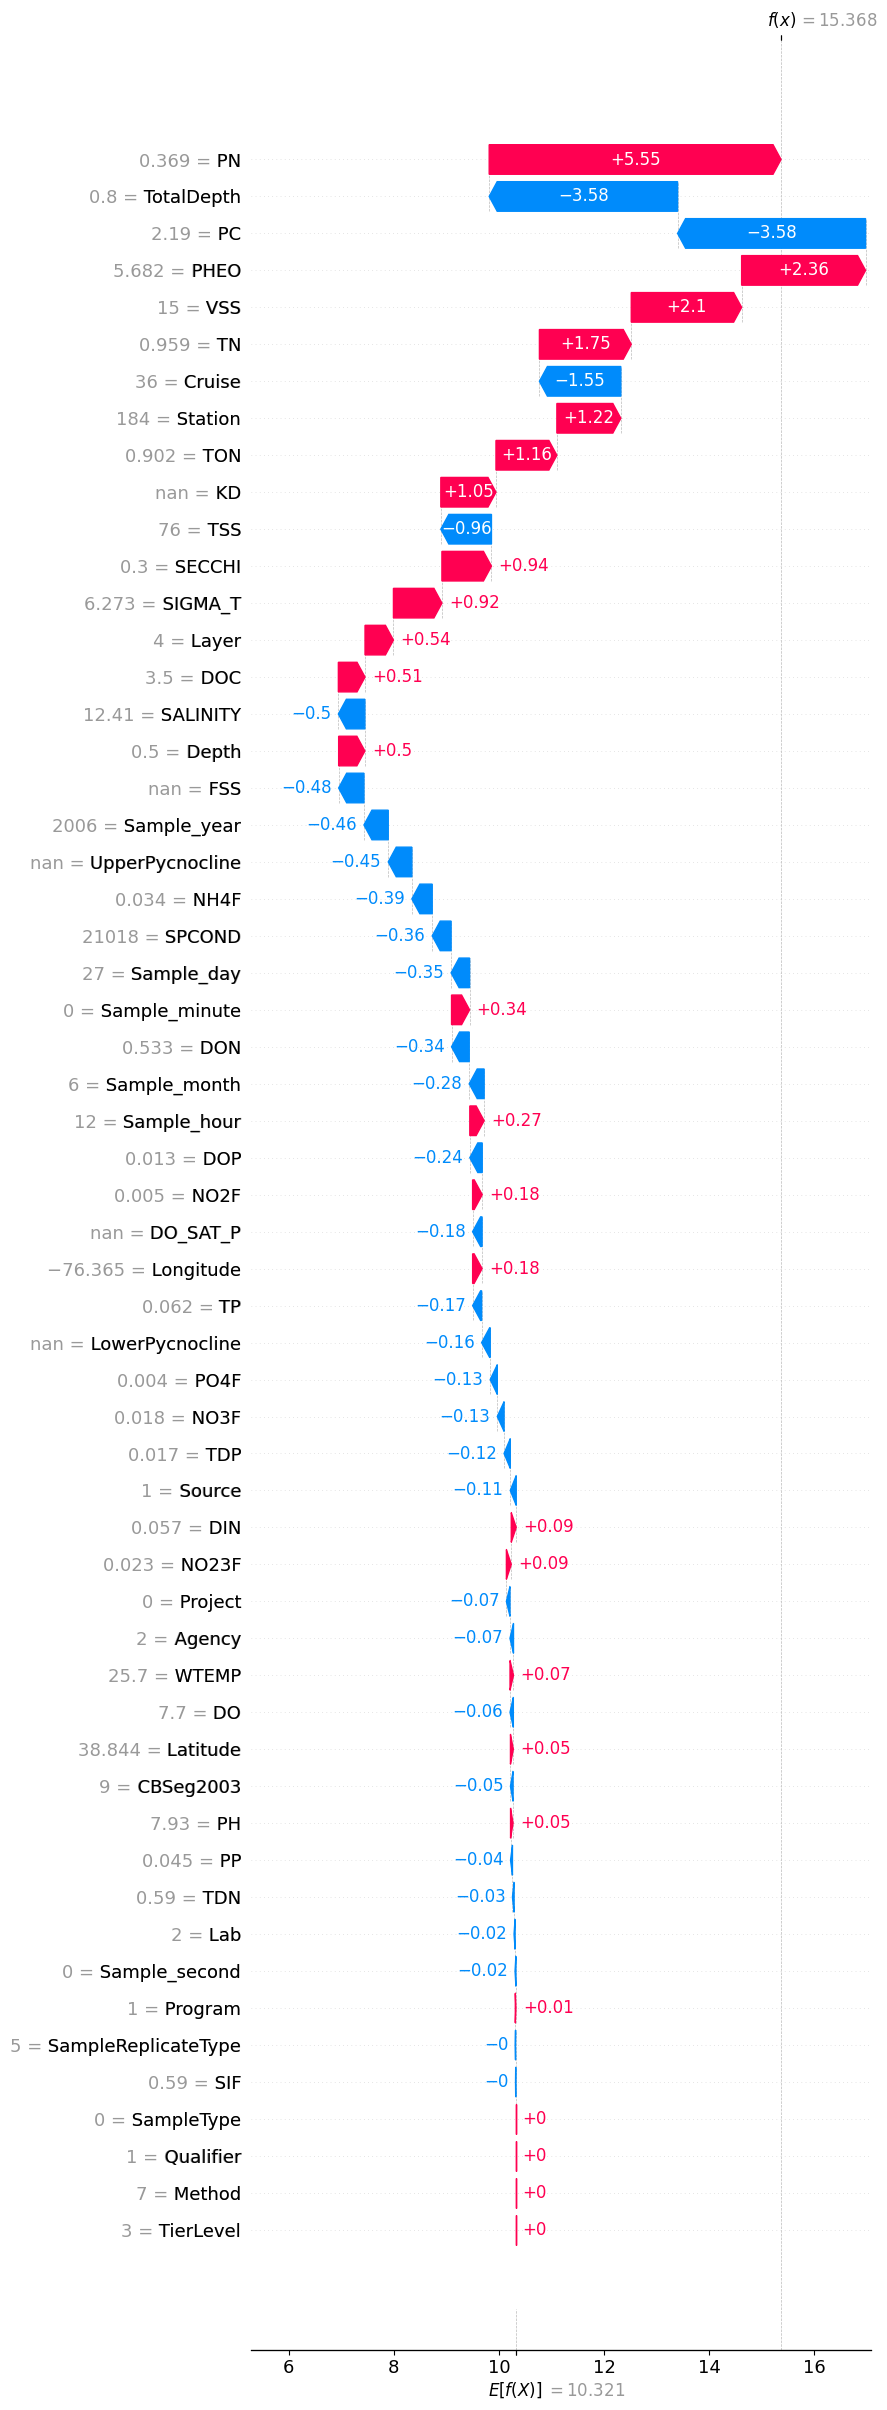

In [47]:
shap.plots.waterfall(shap_values[0], max_display=58)

In [39]:
shap.initjs()

In [48]:
shap.plots.force(shap_values[0])

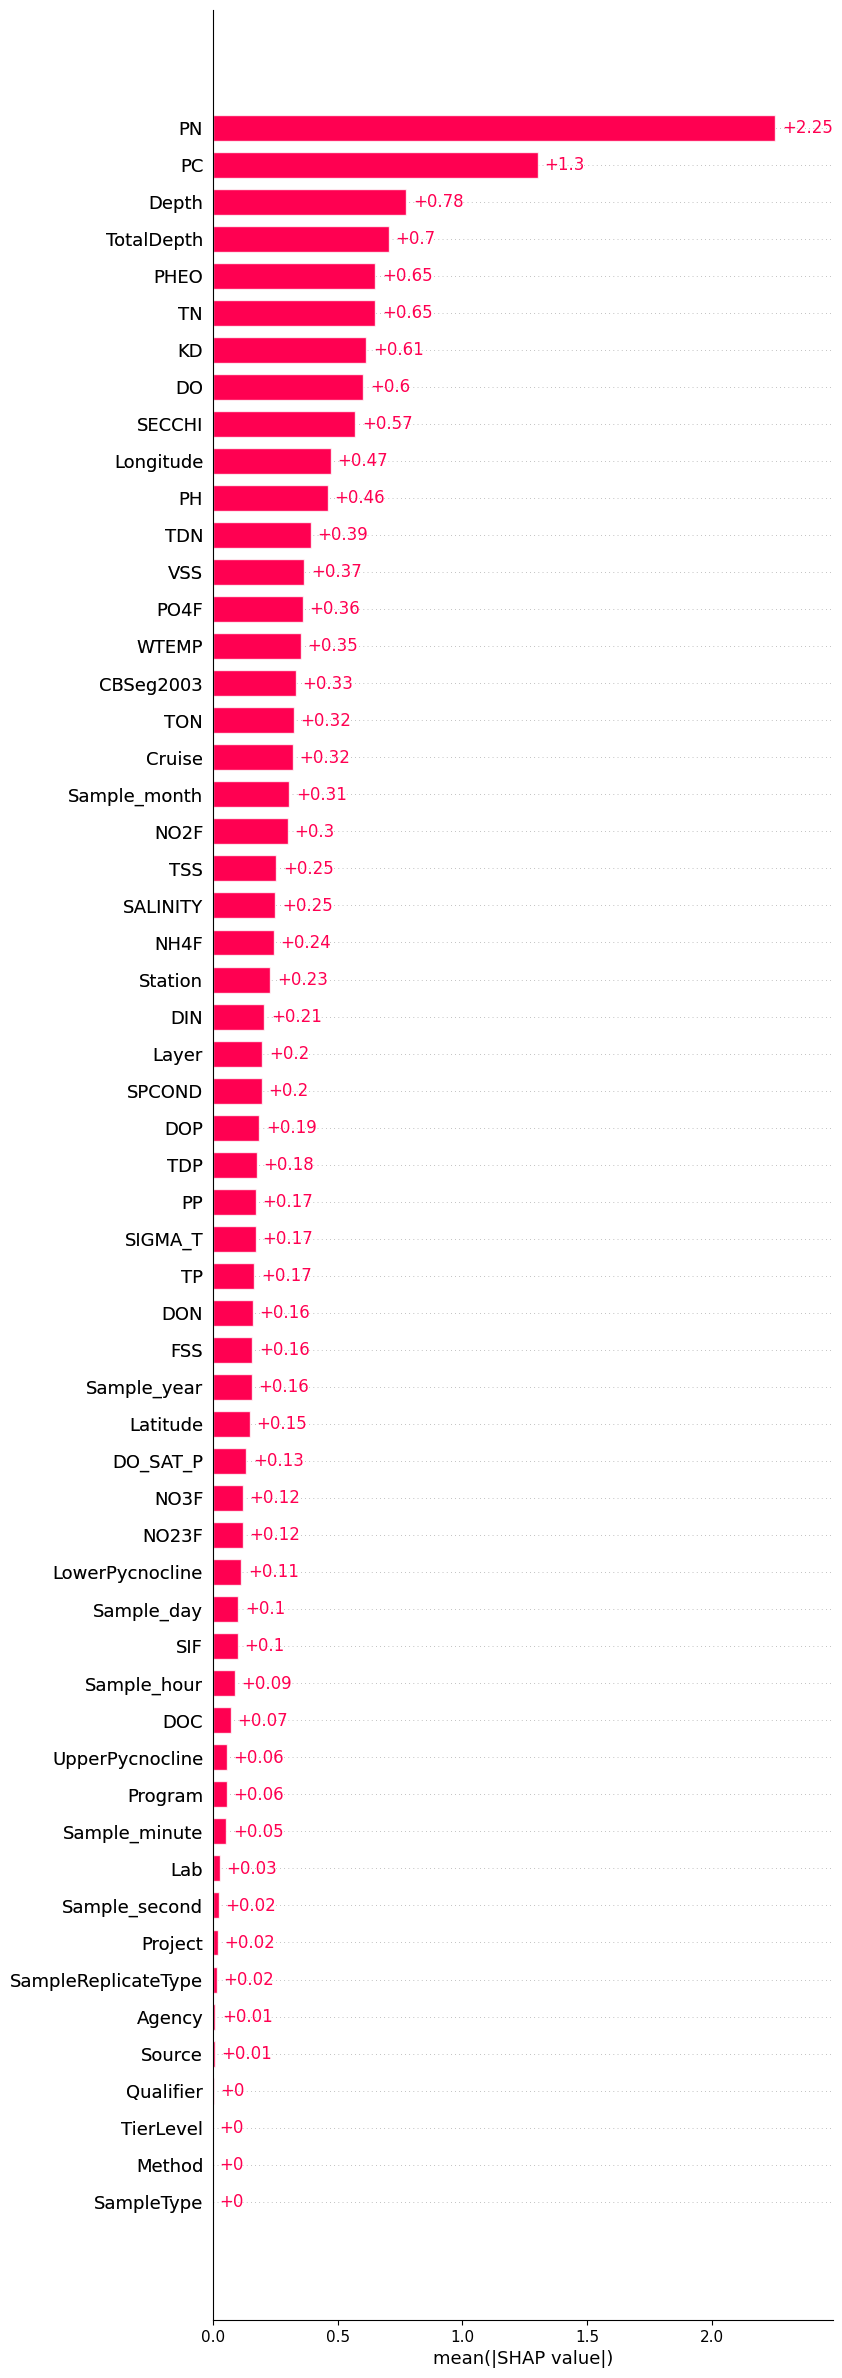

In [44]:
shap.plots.bar(shap_values, max_display=58)

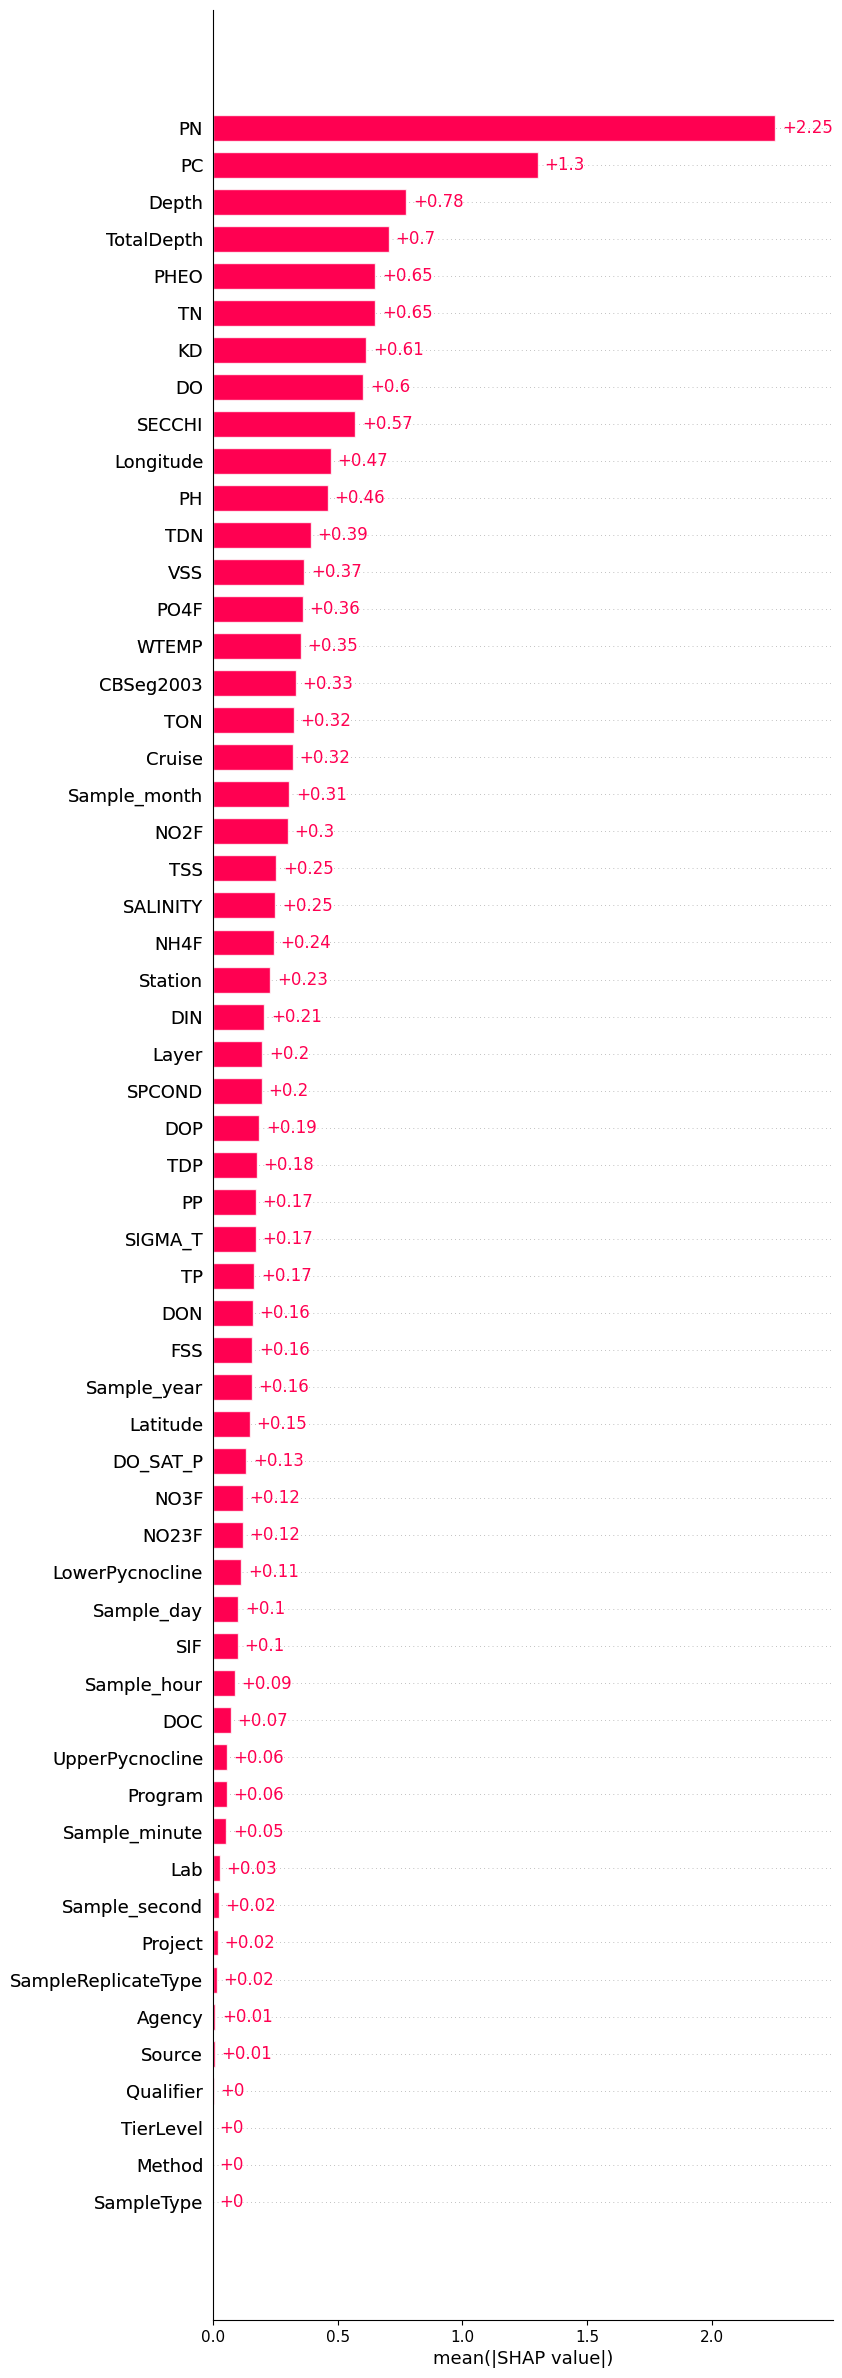

In [45]:
shap.plots.f(shap_values , max_display=58)


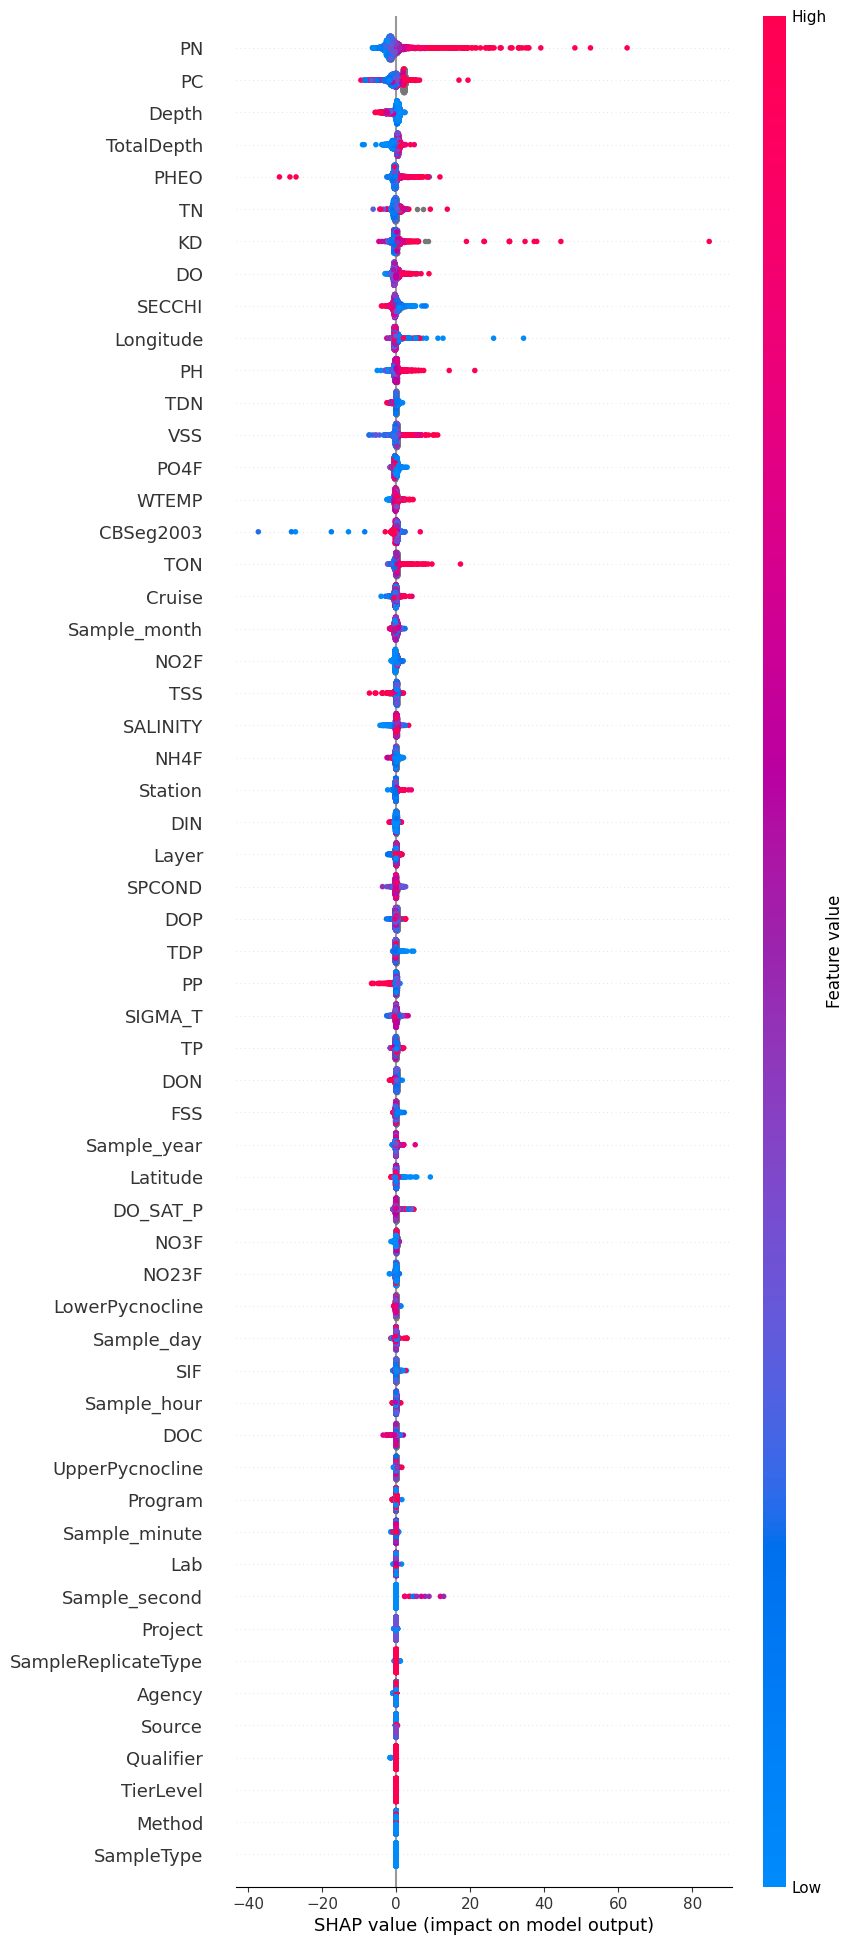

In [43]:
shap.plots.beeswarm(shap_values,max_display=58)